# Bayesian Linear Regression
$$
\mathbf{y} \sim \mathcal{N} \left(\beta^T \mathbf{X}, \sigma^2 \mathbf{I} \right)
$$
Response datapoints $y$ are sampled from a multivariate normal distribution that has a mean equal to the product of the $\beta$ coefficients and the predictors, $X$, and a variance of $\sigma^2$. Here, $I$ refers to the identity matrix, which is necessary because the distribution is multivariate.

In [1]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Need scipy because dataset is in matlab format
import scipy.stats
import scipy.io
from theano import shared
from sklearn.model_selection import train_test_split

Using cuDNN version 7003 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


## Load Dataset

In [2]:
mat = scipy.io.loadmat('data/olympics.mat')
olympics = mat['male100'][:, :2]

In [3]:
datx = olympics[:,0]
daty = olympics[:,1]

In [4]:
X_train, X_test, y, y_test = train_test_split(
            datx, daty, test_size=0.33)
x = shared(X_train)


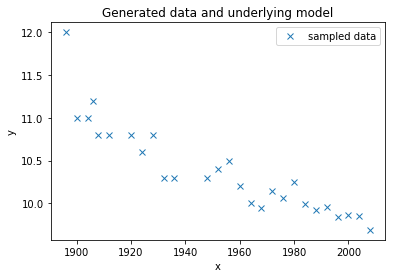

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(datx, daty, 'x', label='sampled data')
plt.legend(loc=0);

Note that we have not normalized the data and this should have a slight impact on the performance of the sampler. This is purely for convenience.

In [6]:
with pm.Model() as model:
    sigma = pm.distributions.Beta('sigma', 1, 2)
    intercept = pm.distributions.Normal('Intercept', 0, sd=20)
    x_coeff = pm.distributions.Normal('x', 0, sd=20)
    
    likelihood = pm.distributions.Normal('y', mu=intercept + x_coeff * x,
                        sd=sigma, observed=y)
    
    start = pm.find_MAP()

    # Use the No-U-Turn Sampler
    step = pm.NUTS()

    # Calculate the trace
    trace = pm.sample(
        1000, step, start, 
        random_seed=42, progressbar=True, njobs=1, chains=2
        )

logp = -27.258, ||grad|| = 0.43604: 100%|██████████| 32/32 [00:00<00:00, 2667.71it/s]  
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma_logodds__]
100%|██████████| 1500/1500 [01:01<00:00, 24.20it/s]
The acceptance probability does not match the target. It is 0.924361241045, but should be close to 0.8. Try to increase the number of tuning steps.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


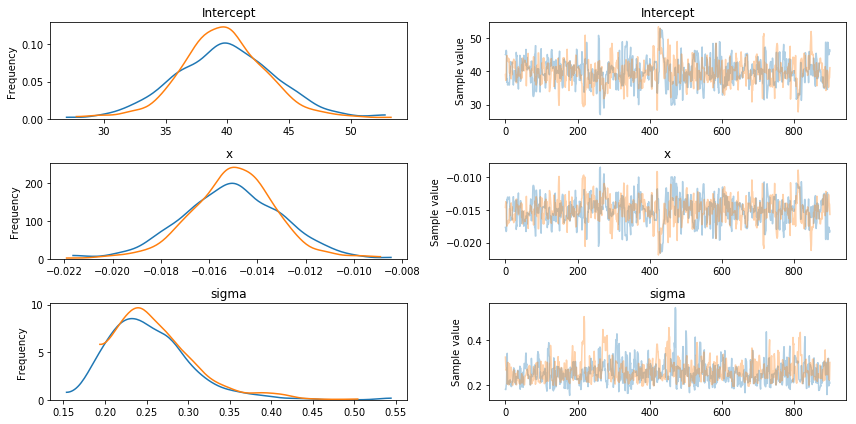

In [7]:
pm.traceplot(trace[100:])
plt.tight_layout();

In [8]:
print(pm.summary(trace[-1000:]))  

                mean        sd  mc_error    hpd_2.5   hpd_97.5  n_eff  \
Intercept  39.874595  3.887553  0.172218  31.840585  47.444366  409.0   
x          -0.015067  0.001983  0.000088  -0.018899  -0.010943  409.0   
sigma       0.259790  0.049544  0.002187   0.174991   0.356384  477.0   

               Rhat  
Intercept  0.999622  
x          0.999608  
sigma      1.004668  


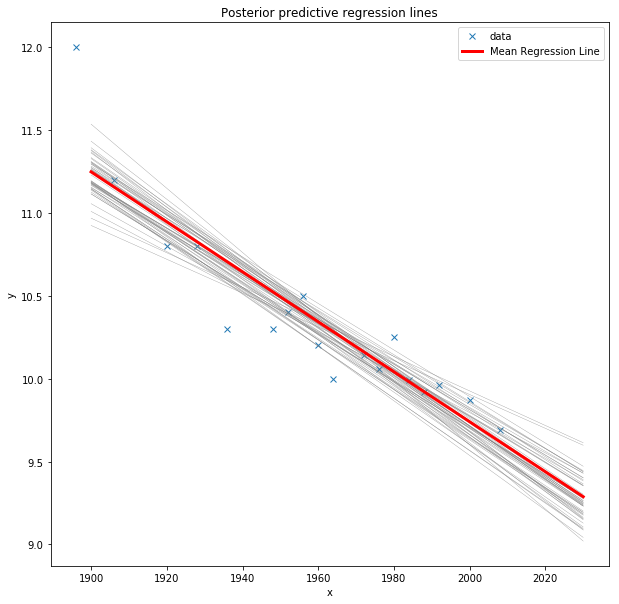

In [9]:
plt.figure(figsize=(10, 10))
lm = lambda x, sample: sample['Intercept'] + sample['x'] * x
eval = np.linspace(1900, 2030, 100)


plt.plot(X_train, y, 'x', label='data')
for rand_loc in np.random.randint(0, len(trace), 50):
        rand_sample = trace[rand_loc]
        plt.plot(eval, lm(eval, rand_sample), color="grey", lw=0.3)
   
intercepts = trace["Intercept"][:, None] 
intercept = np.mean(intercepts); 

ws = trace["x"][:, None] 
w = np.mean(ws);

bx = np.linspace(1900, 2030, 50)
by = intercept + w*bx
plt.plot(bx, by, label="Mean Regression Line", lw=3., c="red")

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');


In [10]:
x.set_value(X_test)
ppc = pm.sample_ppc(trace, model=model, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 3279.54it/s]


In [11]:
mean = np.mean(ppc['y'], 0)
maxe = np.max(ppc['y'], 0) - mean
mine = mean - np.min(ppc['y'], 0) 

In [12]:
errors = np.stack((mine, maxe), 0)

In [13]:
ppc['y'].shape

(1000, 9)

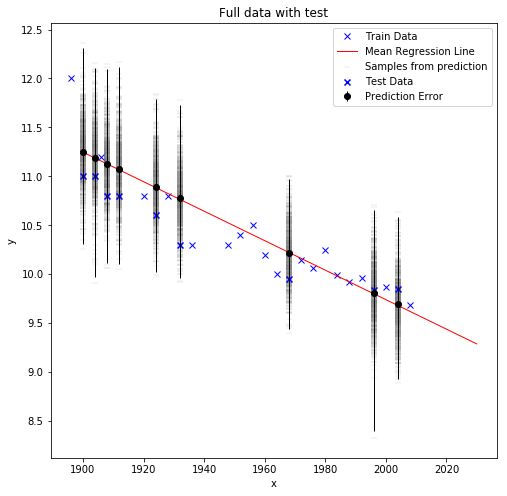

In [14]:
plt.figure(figsize=(8, 8))
plt.errorbar(X_test, mean, yerr=.95*errors, c='black', fmt='o', label='Prediction Error', lw=1)

label='Samples from prediction'
for x in ppc['y']:
    for n, i in enumerate(x):
        plt.scatter(X_test[n], i, marker='_', c="grey", label=label, alpha=0.1)
        label=None
plt.plot(X_train, y, 'x', label='Train Data', c='blue')
plt.scatter(X_test, y_test, marker='x', label='Test Data', c='blue')

plt.plot(bx, by, label="Mean Regression Line", lw=1., c="red")
plt.title('Full data with test')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [15]:
print (np.sum((y_test-mean)**2))

0.687385009193
